In [3]:
#loading time periods
import pyodbc 
from datetime import datetime
from datetime import timezone
from tqdm.notebook import tqdm
import pandas as pd
import requests
import matplotlib.pyplot as plt
import os

os.chdir('./RQ2/')

def drawPlot(data,repo):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.boxplot(data, patch_artist = True,
                     vert = 0,showfliers=False)
    ax.set_xlabel(f"Predicted defect proneness of PRs for {repo}")
    ax.set_ylabel("Period number")
    plt.yticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    ax.yaxis.grid(False) # Hide the horizontal gridlines
    ax.set_xticks([0,0.1,0.2,.3,.4,.5,.6,.7,.8,.9,1])

    ax.xaxis.grid(True) # Show the vertical gridlines
    fig.set_size_inches(9,6);

    image_format = 'svg' # e.g .png, .svg, etc.
    image_name = f'{repo}_analyze_dp_per_period.svg'

#     plt.savefig(f'./{image_name}', format=image_format, dpi=1200)
    
repo_owner='kubernetes'
server = 'localhost' 
database = 'kubernetes' 
username = 'sa' 
password = 'test' 
cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()


In [72]:
cursor.execute(f"""SELECT [Id],[Number],[DefectProneness] from [{database}].[dbo].[PullRequests]""")
PRs = cursor.fetchall() 
DPs = [rows[2] for rows in PRs]



In [73]:
import numpy as np

def defineBoundaries(DPs):
    if len(DPs)==0:
        return [0,1];
    DPs = np.array(DPs)

    q75,q25 = np.percentile(DPs,[75,25])
    intr_qr = q75-q25

    maxVal = min(1,q75+(1.5*intr_qr))
    minVal = max(0,q25-(1.5*intr_qr))
    
    return [minVal,maxVal]



In [77]:
def getDistributionPerPeiod(database):
    # fetch all the PRs
    cursor.execute(f""" SELECT [Id]
        ,[FromDateTime]
        ,[ToDateTime]
      FROM [{database}].[dbo].[Periods]""")
    periods = cursor.fetchall()

    DPs=[]
    for period in periods:
        cursor.execute(f"""SELECT [Id],[Number],[DefectProneness] from [{database}].[dbo].[PullRequests] 
        where [CreatedAtDateTime] < '{period[2]}' and  [CreatedAtDateTime] >= '{period[1]}'  """)
        PRs = cursor.fetchall() 
        DPs+= [[rows[2] for rows in PRs]]
#         print(DPs)
    drawPlot(DPs,database)
    return DPs


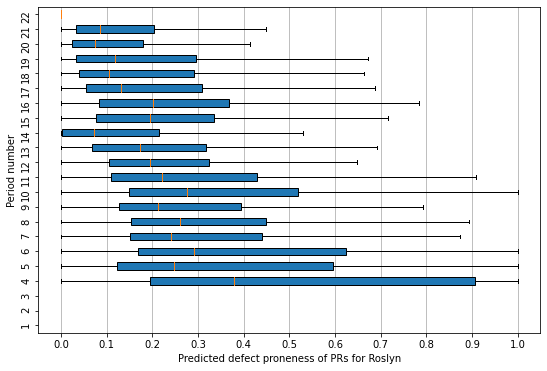

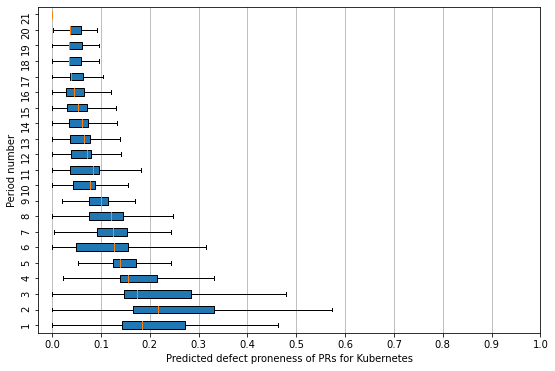

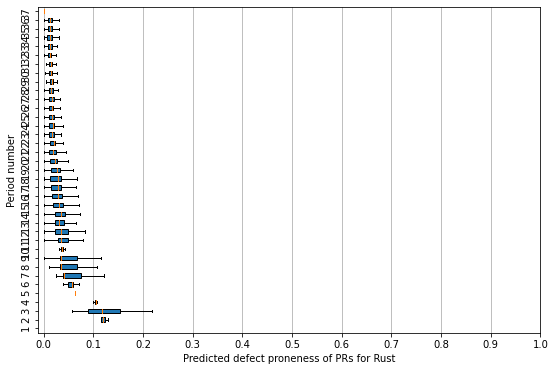

In [80]:
databases = ['Roslyn','Kubernetes','Rust']
dynPeriod = 2
dynamic = {}
normalize = {}
prjIntervals = {}
for database in databases:
    prjIntervals[database] = {'dyn':{},'norm':{}}
    data = getDistributionPerPeiod(database)
    for i in range(0,len(data)):
        dynamic[i] = []
        normalize[i] = []
        for j in range(0,i):
            normalize[i] += data[j]
        for j in range(max(0,i-dynPeriod),i):
            dynamic[i] += data[j]
        
        prjIntervals[database]['norm'][i] = defineBoundaries(normalize[i])
        prjIntervals[database]['dyn'][i] = defineBoundaries(dynamic[i])

In [82]:
prjIntervals

{'Roslyn': {'dyn': {0: [0, 1],
   1: [0, 1],
   2: [0, 1],
   3: [0, 1],
   4: [0, 1],
   5: [0, 1],
   6: [0, 1],
   7: [0, 1],
   8: [0, 0.8848423640546266],
   9: [0, 0.8381301932441236],
   10: [0, 0.9603567560888289],
   11: [0, 1],
   12: [0, 0.7876990600858269],
   13: [0, 0.6824638741995843],
   14: [0, 0.6640835467006471],
   15: [0, 0.6449949836167679],
   16: [0, 0.7578812885923074],
   17: [0, 0.7680168000789399],
   18: [0, 0.6893639441600345],
   19: [0, 0.6671685229768469],
   20: [0, 0.48911880062788893],
   21: [0, 0.43870272064275767]},
  'norm': {0: [0, 1],
   1: [0, 1],
   2: [0, 1],
   3: [0, 1],
   4: [0, 1],
   5: [0, 1],
   6: [0, 1],
   7: [0, 1],
   8: [0, 1],
   9: [0, 1],
   10: [0, 1],
   11: [0, 1],
   12: [0, 0.9775273012638194],
   13: [0, 0.9301280027981027],
   14: [0, 0.8824821053384619],
   15: [0, 0.8698591201203224],
   16: [0, 0.86432099313446],
   17: [0, 0.8527800778888881],
   18: [0, 0.8415768464009132],
   19: [0, 0.8332349166630872],
   20: 

In [84]:
prjIntervals[database]['dyn'][0][0]

0

In [92]:
for database in databases:
    cursor.execute(f""" SELECT [Id]
    ,[FromDateTime]
    ,[ToDateTime]
      FROM [{database}].[dbo].[Periods]""")
    periods = cursor.fetchall()
    for i in periods:
        print(i)
        print(f"""UPDATE [{database}].[dbo].[Periods]
            SET [dynLow]='{prjIntervals[database]['dyn'][i[0]-1][0]}', 
            [dynHigh]='{prjIntervals[database]['dyn'][i[0]-1][1]}',
            [normLow]='{prjIntervals[database]['norm'][i[0]-1][0]}',
            [normHigh]='{prjIntervals[database]['norm'][i[0]-1][1]}'
            WHERE Id='{i[0]}'
        """)
        cursor.execute(f"""UPDATE [{database}].[dbo].[Periods]
            SET [dynLow]='{prjIntervals[database]['dyn'][i[0]-1][0]}', 
            [dynHigh]='{prjIntervals[database]['dyn'][i[0]-1][1]}',
            [normLow]='{prjIntervals[database]['norm'][i[0]-1][0]}',
            [normHigh]='{prjIntervals[database]['norm'][i[0]-1][1]}'
            WHERE Id='{i[0]}'
        """)
        cnxn.commit()

(1, datetime.datetime(2014, 3, 1, 0, 0), datetime.datetime(2014, 6, 1, 0, 0))
UPDATE [Roslyn].[dbo].[Periods]
            SET [dynLow]='0', 
            [dynHigh]='1',
            [normLow]='0',
            [normHigh]='1'
            WHERE Id='1'
        
(2, datetime.datetime(2014, 6, 1, 0, 0), datetime.datetime(2014, 9, 1, 0, 0))
UPDATE [Roslyn].[dbo].[Periods]
            SET [dynLow]='0', 
            [dynHigh]='1',
            [normLow]='0',
            [normHigh]='1'
            WHERE Id='2'
        
(3, datetime.datetime(2014, 9, 1, 0, 0), datetime.datetime(2014, 12, 1, 0, 0))
UPDATE [Roslyn].[dbo].[Periods]
            SET [dynLow]='0', 
            [dynHigh]='1',
            [normLow]='0',
            [normHigh]='1'
            WHERE Id='3'
        
(4, datetime.datetime(2014, 12, 1, 0, 0), datetime.datetime(2015, 3, 1, 0, 0))
UPDATE [Roslyn].[dbo].[Periods]
            SET [dynLow]='0', 
            [dynHigh]='1',
            [normLow]='0',
            [normHigh]='1'
        

TypeError: unhashable type: 'pyodbc.Row'